### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Config

In [8]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")

In [9]:
EXP_NAME

'14-05-2020-09-00'

### Fix Random Seed

In [10]:
seed_torch()

#### Define Writer for Run


In [11]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

### Load Data

In [12]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


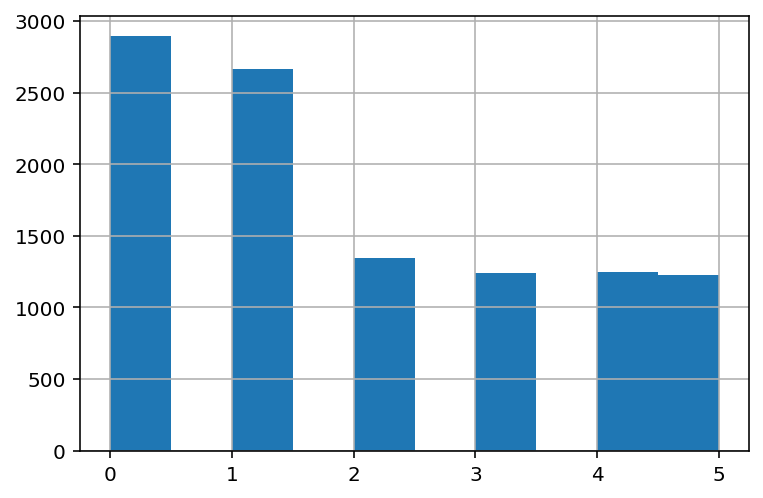

In [13]:
_ = TRAIN_DF[CFG.target_col].hist()

### Train Eval Loop

In [14]:
def train_eval_loop(train_dataset, val_dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=CFG.epoch, tb_tag="", model_name="debug"):
    # Write first layer weights to TB
    if not CFG.debug:
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=0)
    
    # define a data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, num_workers=8)
    model.to(device)
    if CFG.use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=CFG.rlopp, verbose=True)
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    # Define epochs numbers to look into input images and predictions
    # No more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    
    best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)
        
        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        # create random step
        rand_step = np.random.randint(0, len(train_dataloader))
        
        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step
            train_global_step = epoch * len(train_dataloader) + i
            
            inputs, labels = data
            # Visualize input to the model:
            if epoch in visual_epochs and i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=train_global_step, dataformats="HWC")
                del img
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)
            
            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
        
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)
            
            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())
            
            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu')), 
                                  global_step=val_global_step)
        
        # Schedulers
        scheduler.step(val_running_loss)
        # Write lr to TBD
        writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_loss.pth')
            
            # add losses as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=val_global_step)
            
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=val_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_qwk.pth')
            
            # add losses and qwk as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=val_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
    
    writer.close()

### Prepare CV - strategy

In [15]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [16]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [17]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


#### Define Losses

In [18]:
losses_dict = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

### Debug Runs

In [18]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1 loss: ls_soft_ce


In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug="heavy"), debug=False) # NOTE! it is predefined 36-tiles images
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = losses_dict[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=30)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Training Loss: 1.4133	Validation Loss: 1.3378
Counter train preds: Counter({0: 3171, 1: 2178, 5: 974, 3: 583, 4: 559, 2: 497})	Counter val preds: Counter({1: 964, 0: 951, 2: 237, 4: 185, 3: 164, 5: 153})
Epoch train QWK: 0.590	val QWK: 0.636
  Epoch 0 - Save Best Loss: 1.3378 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
  Epoch 0 - Save Best QWK: 0.6357 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
Epoch 1/29


100%|██████████| 166/166 [00:14<00:00, 11.12it/s]


Training Loss: 1.3243	Validation Loss: 1.2604
Counter train preds: Counter({0: 3068, 1: 2105, 5: 931, 3: 659, 4: 614, 2: 585})	Counter val preds: Counter({0: 1165, 5: 408, 1: 357, 2: 345, 3: 195, 4: 184})
Epoch train QWK: 0.663	val QWK: 0.723
  Epoch 1 - Save Best Loss: 1.2604 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
  Epoch 1 - Save Best QWK: 0.7233 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
Epoch 2/29


100%|██████████| 166/166 [00:14<00:00, 11.36it/s]


Training Loss: 1.2768	Validation Loss: 1.2445
Counter train preds: Counter({0: 2990, 1: 2062, 5: 903, 4: 712, 2: 654, 3: 641})	Counter val preds: Counter({0: 988, 1: 664, 5: 486, 3: 310, 4: 129, 2: 77})
Epoch train QWK: 0.694	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2445 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
  Epoch 2 - Save Best QWK: 0.7243 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
Epoch 3/29


100%|██████████| 166/166 [00:16<00:00, 10.25it/s]


Training Loss: 1.2524	Validation Loss: 1.2349
Counter train preds: Counter({0: 2952, 1: 2107, 5: 934, 3: 729, 4: 638, 2: 602})	Counter val preds: Counter({1: 836, 0: 797, 5: 349, 3: 253, 4: 229, 2: 190})
Epoch train QWK: 0.708	val QWK: 0.764
  Epoch 3 - Save Best Loss: 1.2349 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
  Epoch 3 - Save Best QWK: 0.7642 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
Epoch 4/29


100%|██████████| 166/166 [00:15<00:00, 10.78it/s]

Training Loss: 1.2235	Validation Loss: 1.2475
Counter train preds: Counter({0: 2866, 1: 2110, 5: 923, 4: 713, 3: 677, 2: 673})	Counter val preds: Counter({0: 1068, 1: 627, 4: 370, 3: 248, 5: 245, 2: 96})
Epoch train QWK: 0.727	val QWK: 0.739
Epoch 5/29



100%|██████████| 166/166 [00:14<00:00, 11.65it/s]


Training Loss: 1.2193	Validation Loss: 1.2217
Counter train preds: Counter({0: 2865, 1: 2125, 5: 921, 3: 716, 4: 712, 2: 623})	Counter val preds: Counter({1: 887, 0: 850, 3: 307, 4: 232, 2: 218, 5: 160})
Epoch train QWK: 0.735	val QWK: 0.727
  Epoch 5 - Save Best Loss: 1.2217 Model
Confusion matrix, without normalization
[[616  87   2   3   9   6]
 [134 488  24  17   3   0]
 [ 20 209  74  22   7   3]
 [ 28  46  73 130  19  15]
 [ 26  48  24  68 123  24]
 [ 26   9  21  67  71 112]]
Epoch 6/29


100%|██████████| 166/166 [00:15<00:00, 10.50it/s]

Training Loss: 1.1916	Validation Loss: 1.2237
Counter train preds: Counter({0: 2830, 1: 2097, 5: 913, 3: 743, 4: 722, 2: 657})	Counter val preds: Counter({1: 895, 0: 872, 3: 277, 5: 261, 2: 209, 4: 140})
Epoch train QWK: 0.751	val QWK: 0.734
Epoch 7/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]

Training Loss: 1.1780	Validation Loss: 1.2794
Counter train preds: Counter({0: 2802, 1: 2125, 5: 923, 4: 728, 3: 724, 2: 660})	Counter val preds: Counter({0: 1195, 1: 461, 5: 338, 4: 308, 2: 241, 3: 111})
Epoch train QWK: 0.760	val QWK: 0.724
Epoch 8/29



  6%|▋         | 32/498 [00:10<02:30,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.45it/s]

Training Loss: 1.1537	Validation Loss: 1.2326
Counter train preds: Counter({0: 2766, 1: 2073, 5: 922, 4: 753, 2: 727, 3: 721})	Counter val preds: Counter({0: 970, 1: 600, 4: 415, 5: 261, 2: 222, 3: 186})
Epoch train QWK: 0.775	val QWK: 0.742
Epoch 9/29



100%|██████████| 166/166 [00:17<00:00,  9.62it/s]

Epoch    10: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 1.1571	Validation Loss: 1.2449
Counter train preds: Counter({0: 2746, 1: 2079, 5: 912, 3: 791, 4: 745, 2: 689})	Counter val preds: Counter({1: 1001, 0: 814, 5: 246, 2: 221, 3: 219, 4: 153})
Epoch train QWK: 0.767	val QWK: 0.717
Epoch 10/29



100%|██████████| 166/166 [00:14<00:00, 11.80it/s]


Training Loss: 1.0783	Validation Loss: 1.1852
Counter train preds: Counter({0: 2674, 1: 2077, 5: 928, 4: 786, 3: 769, 2: 728})	Counter val preds: Counter({0: 872, 1: 686, 5: 383, 4: 269, 3: 233, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.762
  Epoch 10 - Save Best Loss: 1.1852 Model
Confusion matrix, without normalization
[[633  62   2   5  11  10]
 [139 424  55  26  22   0]
 [ 22 136  95  43  22  17]
 [ 27  31  33 110  43  67]
 [ 27  27  19  35 128  77]
 [ 24   6   7  14  43 212]]
Epoch 11/29


100%|██████████| 166/166 [00:14<00:00, 11.79it/s]


Training Loss: 1.0550	Validation Loss: 1.2170
Counter train preds: Counter({0: 2645, 1: 2025, 5: 936, 4: 803, 2: 797, 3: 756})	Counter val preds: Counter({0: 968, 1: 566, 5: 453, 2: 265, 3: 220, 4: 182})
Epoch train QWK: 0.819	val QWK: 0.766
  Epoch 11 - Save Best QWK: 0.7663 Model
Confusion matrix, without normalization
[[662  45   2   4   3   7]
 [181 366  84  13  15   7]
 [ 35  99 121  45  16  19]
 [ 32  23  34 109  27  86]
 [ 31  29  15  38  97 103]
 [ 27   4   9  11  24 231]]
Epoch 12/29


  8%|▊         | 42/498 [00:13<02:11,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:16<00:00, 10.31it/s]

Training Loss: 1.0295	Validation Loss: 1.2241
Counter train preds: Counter({0: 2631, 1: 2021, 5: 895, 2: 815, 4: 801, 3: 799})	Counter val preds: Counter({0: 921, 1: 797, 5: 258, 3: 255, 4: 222, 2: 201})
Epoch train QWK: 0.821	val QWK: 0.754
Epoch 13/29



100%|██████████| 166/166 [00:14<00:00, 11.82it/s]

Training Loss: 1.0086	Validation Loss: 1.2355
Counter train preds: Counter({0: 2553, 1: 2047, 5: 940, 2: 815, 4: 813, 3: 794})	Counter val preds: Counter({0: 995, 1: 581, 2: 387, 5: 293, 3: 214, 4: 184})
Epoch train QWK: 0.843	val QWK: 0.752
Epoch 14/29



100%|██████████| 166/166 [00:14<00:00, 11.78it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.9891	Validation Loss: 1.2672
Counter train preds: Counter({0: 2550, 1: 2031, 5: 919, 3: 833, 2: 832, 4: 797})	Counter val preds: Counter({0: 854, 1: 731, 4: 385, 5: 364, 2: 190, 3: 130})
Epoch train QWK: 0.844	val QWK: 0.763
Epoch 15/29



100%|██████████| 166/166 [00:15<00:00, 10.71it/s]


Training Loss: 0.9256	Validation Loss: 1.2372
Counter train preds: Counter({0: 2517, 1: 2001, 5: 894, 2: 886, 4: 846, 3: 818})	Counter val preds: Counter({0: 888, 1: 612, 3: 362, 2: 285, 5: 260, 4: 247})
Epoch train QWK: 0.868	val QWK: 0.767
  Epoch 15 - Save Best QWK: 0.7666 Model
Confusion matrix, without normalization
[[631  70   3  13   2   4]
 [146 389  85  35   9   2]
 [ 27  98 137  56  13   4]
 [ 30  21  39 151  38  32]
 [ 30  21  15  67 135  45]
 [ 24  13   6  40  50 173]]
Epoch 16/29


 13%|█▎        | 67/498 [00:20<02:05,  3.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.9068	Validation Loss: 1.2451
Counter train preds: Counter({0: 2501, 1: 1981, 5: 924, 2: 901, 3: 831, 4: 824})	Counter val preds: Counter({0: 868, 1: 740, 2: 287, 3: 280, 5: 247, 4: 232})
Epoch train QWK: 0.876	val QWK: 0.754
Epoch 17/29



100%|██████████| 166/166 [00:15<00:00, 10.44it/s]

Training Loss: 0.8845	Validation Loss: 1.2586
Counter train preds: Counter({0: 2483, 1: 1987, 5: 913, 2: 888, 4: 866, 3: 825})	Counter val preds: Counter({0: 844, 1: 579, 5: 348, 3: 298, 2: 296, 4: 289})
Epoch train QWK: 0.881	val QWK: 0.764
Epoch 18/29



100%|██████████| 166/166 [00:15<00:00, 10.56it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.8628	Validation Loss: 1.2978
Counter train preds: Counter({0: 2465, 1: 1989, 5: 915, 2: 894, 4: 864, 3: 835})	Counter val preds: Counter({0: 817, 1: 634, 2: 407, 5: 305, 3: 289, 4: 202})
Epoch train QWK: 0.893	val QWK: 0.763
Epoch 19/29



100%|██████████| 166/166 [00:14<00:00, 11.44it/s]


Training Loss: 0.8329	Validation Loss: 1.2674
Counter train preds: Counter({0: 2413, 1: 2033, 2: 935, 5: 906, 4: 867, 3: 808})	Counter val preds: Counter({0: 843, 1: 638, 2: 380, 5: 292, 4: 253, 3: 248})
Epoch train QWK: 0.897	val QWK: 0.771
  Epoch 19 - Save Best QWK: 0.7708 Model
Confusion matrix, without normalization
[[617  87   7   4   3   5]
 [127 398 113  17   7   4]
 [ 23  95 157  44  13   3]
 [ 25  24  64 112  44  42]
 [ 24  25  26  42 135  61]
 [ 27   9  13  29  51 177]]
Epoch 20/29


 18%|█▊        | 90/498 [00:28<02:00,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


Training Loss: 0.8309	Validation Loss: 1.2587
Counter train preds: Counter({0: 2444, 1: 1971, 2: 946, 5: 906, 4: 855, 3: 840})	Counter val preds: Counter({0: 905, 1: 645, 5: 348, 2: 288, 4: 254, 3: 214})
Epoch train QWK: 0.895	val QWK: 0.772
  Epoch 20 - Save Best QWK: 0.7721 Model
Confusion matrix, without normalization
[[638  67   7   5   2   4]
 [156 399  82  11  13   5]
 [ 27 112 129  38  19  10]
 [ 30  31  46 104  49  51]
 [ 29  25  16  32 137  74]
 [ 25  11   8  24  34 204]]
Epoch 21/29


100%|██████████| 166/166 [00:16<00:00, 10.07it/s]

Training Loss: 0.8118	Validation Loss: 1.2990
Counter train preds: Counter({0: 2425, 1: 1992, 2: 920, 5: 913, 4: 863, 3: 849})	Counter val preds: Counter({0: 863, 1: 560, 2: 397, 4: 287, 3: 274, 5: 273})
Epoch train QWK: 0.904	val QWK: 0.766
Epoch 22/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]


Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.8106	Validation Loss: 1.2867
Counter train preds: Counter({0: 2392, 1: 2022, 2: 934, 5: 910, 4: 880, 3: 824})	Counter val preds: Counter({0: 844, 1: 588, 2: 388, 5: 310, 4: 274, 3: 250})
Epoch train QWK: 0.898	val QWK: 0.773
  Epoch 22 - Save Best QWK: 0.7731 Model
Confusion matrix, without normalization
[[610  87  10   6   5   5]
 [139 365 121  26  10   5]
 [ 24  80 164  46  17   4]
 [ 21  24  62 114  45  45]
 [ 25  24  18  39 147  60]
 [ 25   8  13  19  50 191]]
Epoch 23/29


100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Training Loss: 0.7927	Validation Loss: 1.2908
Counter train preds: Counter({0: 2397, 1: 1984, 5: 944, 2: 931, 3: 874, 4: 832})	Counter val preds: Counter({0: 840, 1: 644, 2: 377, 5: 274, 3: 270, 4: 249})
Epoch train QWK: 0.906	val QWK: 0.766
Epoch 24/29



 41%|████      | 204/498 [01:01<01:24,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]

Training Loss: 0.7887	Validation Loss: 1.2833
Counter train preds: Counter({0: 2403, 1: 1975, 2: 947, 5: 891, 4: 890, 3: 856})	Counter val preds: Counter({0: 863, 1: 672, 2: 376, 4: 297, 5: 265, 3: 181})
Epoch train QWK: 0.906	val QWK: 0.760
Epoch 25/29



100%|██████████| 166/166 [00:14<00:00, 11.74it/s]

Training Loss: 0.7820	Validation Loss: 1.2766
Counter train preds: Counter({0: 2399, 1: 1977, 2: 951, 5: 904, 4: 874, 3: 857})	Counter val preds: Counter({0: 859, 1: 629, 2: 323, 3: 313, 5: 275, 4: 255})
Epoch train QWK: 0.907	val QWK: 0.765
Epoch 26/29



100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.7875	Validation Loss: 1.2824
Counter train preds: Counter({0: 2443, 1: 1964, 2: 935, 5: 905, 3: 877, 4: 838})	Counter val preds: Counter({0: 838, 1: 655, 2: 371, 5: 292, 3: 290, 4: 208})
Epoch train QWK: 0.906	val QWK: 0.759
Epoch 27/29



100%|██████████| 166/166 [00:15<00:00, 10.60it/s]

Training Loss: 0.7610	Validation Loss: 1.3068
Counter train preds: Counter({0: 2411, 1: 1954, 2: 952, 5: 937, 4: 861, 3: 847})	Counter val preds: Counter({0: 886, 1: 561, 2: 348, 3: 338, 5: 284, 4: 237})
Epoch train QWK: 0.917	val QWK: 0.759
Epoch 28/29



 51%|█████▏    | 256/498 [01:17<01:09,  3.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.7612	Validation Loss: 1.2853
Counter train preds: Counter({0: 2396, 1: 1962, 2: 947, 5: 916, 4: 880, 3: 861})	Counter val preds: Counter({0: 855, 1: 665, 2: 342, 5: 313, 3: 248, 4: 231})
Epoch train QWK: 0.917	val QWK: 0.764
Epoch 29/29



100%|██████████| 166/166 [00:14<00:00, 11.73it/s]

Training Loss: 0.7683	Validation Loss: 1.2812
Counter train preds: Counter({0: 2405, 1: 1990, 2: 934, 5: 886, 4: 880, 3: 867})	Counter val preds: Counter({0: 888, 1: 609, 2: 364, 5: 295, 3: 262, 4: 236})
Epoch train QWK: 0.914	val QWK: 0.762


### Experiment Run

In [20]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 use_amp: True
 img_height: 768
 img_width: 768
 lr: 5e-05
 rlopp: 3
 batch_size: 8
 epoch: 50
 seed: 1982
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 n_fold: 4
 tiff_layer: 1
 loss: ls_soft_ce
 stoch_sample: True
 num_tiles: 144
 tile_sz: 64



In [21]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug="light"), debug=False)
val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = losses_dict[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/49


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]


Training Loss: 1.3755	Validation Loss: 1.2732
Counter train preds: Counter({0: 3083, 1: 2200, 5: 946, 3: 596, 4: 586, 2: 551})	Counter val preds: Counter({1: 1005, 0: 920, 5: 292, 3: 156, 2: 153, 4: 128})
Epoch train QWK: 0.600	val QWK: 0.671
  Epoch 0 - Save Best Loss: 1.2732 Model
Confusion matrix, without normalization
[[622  88   1   0   9   3]
 [141 511   9   3   1   1]
 [ 30 228  56   9   1  11]
 [ 40  93  57  62  10  49]
 [ 46  61  20  46  71  69]
 [ 41  24  10  36  36 159]]
  Epoch 0 - Save Best QWK: 0.6713 Model
Confusion matrix, without normalization
[[622  88   1   0   9   3]
 [141 511   9   3   1   1]
 [ 30 228  56   9   1  11]
 [ 40  93  57  62  10  49]
 [ 46  61  20  46  71  69]
 [ 41  24  10  36  36 159]]
Epoch 1/49


100%|██████████| 332/332 [01:55<00:00,  2.88it/s]


Training Loss: 1.2677	Validation Loss: 1.2512
Counter train preds: Counter({0: 2887, 1: 2165, 5: 938, 4: 715, 3: 629, 2: 628})	Counter val preds: Counter({0: 979, 5: 544, 1: 447, 2: 320, 4: 205, 3: 159})
Epoch train QWK: 0.691	val QWK: 0.738
  Epoch 1 - Save Best Loss: 1.2512 Model
Confusion matrix, without normalization
[[671  27   3   1  13   8]
 [162 318 148  15  17   6]
 [ 39  60 133  44  22  37]
 [ 38  19  18  61  34 141]
 [ 38  16  15  26  92 126]
 [ 31   7   3  12  27 226]]
  Epoch 1 - Save Best QWK: 0.7376 Model
Confusion matrix, without normalization
[[671  27   3   1  13   8]
 [162 318 148  15  17   6]
 [ 39  60 133  44  22  37]
 [ 38  19  18  61  34 141]
 [ 38  16  15  26  92 126]
 [ 31   7   3  12  27 226]]
Epoch 2/49


  3%|▎         | 34/996 [00:17<06:14,  2.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:55<00:00,  2.88it/s]


Training Loss: 1.2324	Validation Loss: 1.1762
Counter train preds: Counter({0: 2772, 1: 2182, 5: 904, 4: 768, 2: 691, 3: 645})	Counter val preds: Counter({0: 873, 1: 690, 5: 463, 3: 298, 4: 180, 2: 150})
Epoch train QWK: 0.716	val QWK: 0.777
  Epoch 2 - Save Best Loss: 1.1762 Model
Confusion matrix, without normalization
[[651  52   1   3  12   4]
 [129 444  39  37  10   7]
 [ 16 130  83  72  12  22]
 [ 33  28  16 120  35  79]
 [ 21  27   8  39  91 127]
 [ 23   9   3  27  20 224]]
  Epoch 2 - Save Best QWK: 0.7768 Model
Confusion matrix, without normalization
[[651  52   1   3  12   4]
 [129 444  39  37  10   7]
 [ 16 130  83  72  12  22]
 [ 33  28  16 120  35  79]
 [ 21  27   8  39  91 127]
 [ 23   9   3  27  20 224]]
Epoch 3/49


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]


Training Loss: 1.2092	Validation Loss: 1.1752
Counter train preds: Counter({0: 2779, 1: 2142, 5: 981, 4: 716, 2: 674, 3: 670})	Counter val preds: Counter({1: 783, 0: 758, 5: 392, 3: 269, 4: 236, 2: 216})
Epoch train QWK: 0.735	val QWK: 0.789
  Epoch 3 - Save Best Loss: 1.1752 Model
Confusion matrix, without normalization
[[602 103   2   2   7   7]
 [ 84 476  73  22   8   3]
 [ 14 122 101  80  12   6]
 [ 23  37  25 105  46  75]
 [ 17  28  10  41 124  93]
 [ 18  17   5  19  39 208]]
  Epoch 3 - Save Best QWK: 0.7893 Model
Confusion matrix, without normalization
[[602 103   2   2   7   7]
 [ 84 476  73  22   8   3]
 [ 14 122 101  80  12   6]
 [ 23  37  25 105  46  75]
 [ 17  28  10  41 124  93]
 [ 18  17   5  19  39 208]]
Epoch 4/49


  8%|▊         | 77/996 [00:32<05:35,  2.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:54<00:00,  2.91it/s]

Training Loss: 1.1868	Validation Loss: 1.1781
Counter train preds: Counter({0: 2724, 1: 2134, 5: 942, 4: 733, 2: 726, 3: 703})	Counter val preds: Counter({0: 942, 1: 714, 5: 306, 3: 295, 4: 208, 2: 189})
Epoch train QWK: 0.752	val QWK: 0.759
Epoch 5/49



100%|██████████| 332/332 [01:56<00:00,  2.86it/s]


Training Loss: 1.1618	Validation Loss: 1.1471
Counter train preds: Counter({0: 2717, 1: 2150, 5: 925, 4: 756, 3: 724, 2: 690})	Counter val preds: Counter({0: 864, 1: 724, 3: 415, 4: 298, 5: 185, 2: 168})
Epoch train QWK: 0.759	val QWK: 0.773
  Epoch 5 - Save Best Loss: 1.1471 Model
Confusion matrix, without normalization
[[653  62   2   3   0   3]
 [105 482  46  27   5   1]
 [ 13 120  87  98  13   4]
 [ 38  20  19 164  50  20]
 [ 28  31  11  67 151  25]
 [ 27   9   3  56  79 132]]
Epoch 6/49


 30%|██▉       | 297/996 [01:56<04:24,  2.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 1.1403	Validation Loss: 1.1501
Counter train preds: Counter({0: 2654, 1: 2186, 5: 918, 4: 749, 2: 739, 3: 716})	Counter val preds: Counter({1: 850, 0: 808, 5: 342, 3: 283, 4: 186, 2: 185})
Epoch train QWK: 0.781	val QWK: 0.788
Epoch 7/49



100%|██████████| 332/332 [01:56<00:00,  2.86it/s]

Training Loss: 1.1391	Validation Loss: 1.2099
Counter train preds: Counter({0: 2676, 1: 2153, 5: 895, 4: 785, 3: 736, 2: 717})	Counter val preds: Counter({0: 921, 1: 539, 5: 411, 4: 400, 2: 241, 3: 142})
Epoch train QWK: 0.780	val QWK: 0.775
Epoch 8/49



 77%|███████▋  | 768/996 [04:51<01:28,  2.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 1.1192	Validation Loss: 1.1520
Counter train preds: Counter({0: 2638, 1: 2149, 5: 917, 4: 784, 2: 754, 3: 720})	Counter val preds: Counter({0: 809, 1: 794, 4: 294, 5: 283, 2: 275, 3: 199})
Epoch train QWK: 0.790	val QWK: 0.788
Epoch 9/49



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


Training Loss: 1.1123	Validation Loss: 1.1279
Counter train preds: Counter({0: 2642, 1: 2144, 5: 926, 4: 785, 2: 742, 3: 723})	Counter val preds: Counter({0: 838, 1: 813, 3: 409, 5: 275, 4: 189, 2: 130})
Epoch train QWK: 0.790	val QWK: 0.788
  Epoch 9 - Save Best Loss: 1.1279 Model
Confusion matrix, without normalization
[[653  55   0   3   8   4]
 [106 508  24  22   5   1]
 [ 13 165  72  75   7   3]
 [ 27  39  20 175  21  29]
 [ 21  28   9  81 115  59]
 [ 18  18   5  53  33 179]]
Epoch 10/49


100%|██████████| 996/996 [06:18<00:00,  2.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


Training Loss: 1.0982	Validation Loss: 1.1536
Counter train preds: Counter({0: 2609, 1: 2166, 5: 931, 4: 780, 2: 741, 3: 735})	Counter val preds: Counter({0: 769, 1: 762, 5: 378, 3: 304, 2: 223, 4: 218})
Epoch train QWK: 0.800	val QWK: 0.790
  Epoch 10 - Save Best QWK: 0.7898 Model
Confusion matrix, without normalization
[[627  65   6   7  10   8]
 [ 76 507  44  20   7  12]
 [ 10 141 106  49  11  18]
 [ 21  21  46 136  32  55]
 [ 18  22  14  63 113  83]
 [ 17   6   7  29  45 202]]
Epoch 11/49


100%|██████████| 332/332 [01:54<00:00,  2.89it/s]


Training Loss: 1.0942	Validation Loss: 1.1428
Counter train preds: Counter({0: 2596, 1: 2179, 5: 938, 4: 774, 2: 743, 3: 732})	Counter val preds: Counter({1: 829, 0: 816, 5: 462, 3: 315, 2: 128, 4: 104})
Epoch train QWK: 0.798	val QWK: 0.806
  Epoch 11 - Save Best QWK: 0.8056 Model
Confusion matrix, without normalization
[[646  65   1   6   2   3]
 [106 509  27  18   3   3]
 [ 14 172  70  49   6  24]
 [ 17  38  19 142  12  83]
 [ 18  29   7  70  71 118]
 [ 15  16   4  30  10 231]]
Epoch 12/49


100%|██████████| 332/332 [01:55<00:00,  2.88it/s]

Training Loss: 1.0848	Validation Loss: 1.1564
Counter train preds: Counter({0: 2587, 1: 2186, 5: 874, 4: 784, 3: 781, 2: 750})	Counter val preds: Counter({0: 839, 1: 667, 3: 417, 5: 296, 2: 273, 4: 162})
Epoch train QWK: 0.810	val QWK: 0.791
Epoch 13/49



  3%|▎         | 31/996 [00:15<06:14,  2.58it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.72it/s]

Epoch    14: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 1.0746	Validation Loss: 1.1286
Counter train preds: Counter({0: 2574, 1: 2153, 5: 915, 4: 789, 3: 773, 2: 758})	Counter val preds: Counter({0: 945, 1: 665, 3: 384, 5: 307, 4: 183, 2: 170})
Epoch train QWK: 0.813	val QWK: 0.776
Epoch 14/49



100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 1.0312	Validation Loss: 1.1527
Counter train preds: Counter({0: 2531, 1: 2144, 5: 913, 3: 804, 2: 787, 4: 783})	Counter val preds: Counter({1: 1012, 0: 692, 5: 315, 3: 266, 4: 223, 2: 146})
Epoch train QWK: 0.837	val QWK: 0.805
Epoch 15/49



  7%|▋         | 70/996 [00:29<05:33,  2.78it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:02<00:00,  2.71it/s]


Training Loss: 1.0147	Validation Loss: 1.0987
Counter train preds: Counter({0: 2542, 1: 2116, 5: 897, 2: 813, 4: 813, 3: 781})	Counter val preds: Counter({0: 810, 1: 769, 5: 339, 3: 312, 4: 238, 2: 186})
Epoch train QWK: 0.840	val QWK: 0.810
  Epoch 15 - Save Best Loss: 1.0987 Model
Confusion matrix, without normalization
[[654  58   2   4   3   2]
 [ 88 502  45  19   8   4]
 [ 10 138 104  57  12  14]
 [ 21  34  26 140  38  52]
 [ 18  28   7  58 134  68]
 [ 19   9   2  34  43 199]]
  Epoch 15 - Save Best QWK: 0.8097 Model
Confusion matrix, without normalization
[[654  58   2   4   3   2]
 [ 88 502  45  19   8   4]
 [ 10 138 104  57  12  14]
 [ 21  34  26 140  38  52]
 [ 18  28   7  58 134  68]
 [ 19   9   2  34  43 199]]
Epoch 16/49


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]


Training Loss: 1.0045	Validation Loss: 1.1057
Counter train preds: Counter({0: 2534, 1: 2124, 5: 874, 4: 826, 2: 815, 3: 789})	Counter val preds: Counter({1: 864, 0: 694, 3: 354, 4: 267, 5: 258, 2: 217})
Epoch train QWK: 0.841	val QWK: 0.818
  Epoch 16 - Save Best QWK: 0.8185 Model
Confusion matrix, without normalization
[[595 112   1   4   6   5]
 [ 56 540  40  23   4   3]
 [  5 136 119  63   8   4]
 [ 16  32  36 167  36  24]
 [  9  31  12  64 157  40]
 [ 13  13   9  33  56 182]]
Epoch 17/49


 12%|█▏        | 117/996 [00:48<06:09,  2.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:57<00:00,  2.83it/s]

Training Loss: 0.9913	Validation Loss: 1.1283
Counter train preds: Counter({0: 2499, 1: 2098, 5: 887, 4: 850, 2: 833, 3: 795})	Counter val preds: Counter({0: 759, 1: 748, 4: 321, 3: 315, 5: 306, 2: 205})
Epoch train QWK: 0.843	val QWK: 0.812
Epoch 18/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.9867	Validation Loss: 1.1085
Counter train preds: Counter({0: 2478, 1: 2141, 5: 901, 3: 822, 4: 812, 2: 808})	Counter val preds: Counter({0: 807, 1: 688, 3: 402, 5: 296, 2: 257, 4: 204})
Epoch train QWK: 0.847	val QWK: 0.816
Epoch 19/49



 30%|██▉       | 295/996 [02:02<04:10,  2.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:54<00:00,  2.89it/s]

Epoch    20: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.9804	Validation Loss: 1.1356
Counter train preds: Counter({0: 2505, 1: 2125, 5: 876, 3: 827, 4: 821, 2: 808})	Counter val preds: Counter({0: 819, 1: 623, 3: 408, 2: 305, 4: 257, 5: 242})
Epoch train QWK: 0.855	val QWK: 0.817
Epoch 20/49



100%|██████████| 332/332 [01:55<00:00,  2.87it/s]


Training Loss: 0.9634	Validation Loss: 1.0877
Counter train preds: Counter({0: 2502, 1: 2091, 5: 909, 2: 854, 4: 816, 3: 790})	Counter val preds: Counter({0: 792, 1: 741, 5: 327, 3: 299, 4: 261, 2: 234})
Epoch train QWK: 0.859	val QWK: 0.820
  Epoch 20 - Save Best Loss: 1.0877 Model
Confusion matrix, without normalization
[[645  62   4   4   5   3]
 [ 80 505  56  17   4   4]
 [ 13 116 129  51  16  10]
 [ 19  26  27 155  46  38]
 [ 14  26  10  50 150  63]
 [ 21   6   8  22  40 209]]
  Epoch 20 - Save Best QWK: 0.8198 Model
Confusion matrix, without normalization
[[645  62   4   4   5   3]
 [ 80 505  56  17   4   4]
 [ 13 116 129  51  16  10]
 [ 19  26  27 155  46  38]
 [ 14  26  10  50 150  63]
 [ 21   6   8  22  40 209]]
Epoch 21/49


 32%|███▏      | 315/996 [02:02<04:05,  2.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 65%|██████▌   | 649/996 [04:10<02:01,  2.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:58<00:00,  2.80it/s]

Training Loss: 0.9454	Validation Loss: 1.1017
Counter train preds: Counter({0: 2493, 1: 2081, 5: 894, 4: 850, 2: 847, 3: 797})	Counter val preds: Counter({0: 808, 1: 738, 3: 349, 4: 278, 2: 242, 5: 239})
Epoch train QWK: 0.866	val QWK: 0.813
Epoch 22/49



100%|██████████| 332/332 [02:00<00:00,  2.76it/s]

Training Loss: 0.9367	Validation Loss: 1.1418
Counter train preds: Counter({0: 2459, 1: 2079, 5: 885, 4: 868, 2: 846, 3: 825})	Counter val preds: Counter({1: 744, 0: 716, 5: 442, 3: 307, 2: 247, 4: 198})
Epoch train QWK: 0.871	val QWK: 0.819
Epoch 23/49



100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


Training Loss: 0.9343	Validation Loss: 1.1004
Counter train preds: Counter({0: 2477, 1: 2078, 5: 902, 2: 866, 4: 823, 3: 816})	Counter val preds: Counter({0: 810, 1: 676, 4: 364, 3: 320, 5: 291, 2: 193})
Epoch train QWK: 0.864	val QWK: 0.822
  Epoch 23 - Save Best QWK: 0.8215 Model
Confusion matrix, without normalization
[[661  40   3   6   8   5]
 [ 88 480  52  27  14   5]
 [ 12 109 107  76  23   8]
 [ 19  20  18 147  79  28]
 [ 16  21   7  41 184  44]
 [ 14   6   6  23  56 201]]
Epoch 24/49


100%|██████████| 332/332 [01:57<00:00,  2.83it/s]

Epoch    25: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.9302	Validation Loss: 1.0924
Counter train preds: Counter({0: 2471, 1: 2068, 5: 888, 2: 856, 4: 843, 3: 836})	Counter val preds: Counter({0: 804, 1: 742, 5: 349, 3: 282, 4: 263, 2: 214})
Epoch train QWK: 0.869	val QWK: 0.821
Epoch 25/49



 70%|███████   | 699/996 [04:24<01:44,  2.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]


Training Loss: 0.9162	Validation Loss: 1.1140
Counter train preds: Counter({0: 2463, 1: 2087, 5: 886, 2: 874, 4: 852, 3: 800})	Counter val preds: Counter({1: 757, 0: 747, 3: 419, 5: 276, 4: 246, 2: 209})
Epoch train QWK: 0.874	val QWK: 0.826
  Epoch 25 - Save Best QWK: 0.8257 Model
Confusion matrix, without normalization
[[626  76   2  11   2   6]
 [ 76 496  56  27   6   5]
 [ 13 117 115  76  11   3]
 [ 12  31  20 185  38  25]
 [ 10  29   8  78 143  45]
 [ 10   8   8  42  46 192]]
Epoch 26/49


100%|██████████| 332/332 [02:03<00:00,  2.70it/s]

Training Loss: 0.9110	Validation Loss: 1.1283
Counter train preds: Counter({0: 2446, 1: 2117, 5: 884, 2: 857, 4: 832, 3: 826})	Counter val preds: Counter({0: 787, 1: 714, 5: 340, 3: 335, 2: 258, 4: 220})
Epoch train QWK: 0.876	val QWK: 0.820
Epoch 27/49



 48%|████▊     | 474/996 [03:04<03:06,  2.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 0.9067	Validation Loss: 1.1306
Counter train preds: Counter({0: 2442, 1: 2098, 5: 895, 4: 853, 2: 849, 3: 825})	Counter val preds: Counter({0: 814, 1: 643, 3: 381, 4: 276, 2: 273, 5: 267})
Epoch train QWK: 0.876	val QWK: 0.820
Epoch 28/49



100%|██████████| 332/332 [01:55<00:00,  2.87it/s]


Epoch    29: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.8999	Validation Loss: 1.1266
Counter train preds: Counter({0: 2464, 1: 2088, 5: 870, 2: 854, 4: 845, 3: 841})	Counter val preds: Counter({0: 790, 1: 666, 3: 368, 5: 306, 2: 264, 4: 260})
Epoch train QWK: 0.877	val QWK: 0.826
  Epoch 28 - Save Best QWK: 0.8263 Model
Confusion matrix, without normalization
[[653  50   6   7   3   4]
 [ 80 474  80  21   9   2]
 [ 12 100 131  63  19  10]
 [ 14  18  28 165  55  31]
 [ 16  17  13  73 141  53]
 [ 15   7   6  39  33 206]]
Epoch 29/49


100%|██████████| 332/332 [01:55<00:00,  2.88it/s]


Training Loss: 0.8977	Validation Loss: 1.1056
Counter train preds: Counter({0: 2449, 1: 2066, 5: 900, 2: 869, 4: 857, 3: 821})	Counter val preds: Counter({0: 783, 1: 717, 5: 368, 3: 319, 2: 252, 4: 215})
Epoch train QWK: 0.887	val QWK: 0.829
  Epoch 29 - Save Best QWK: 0.8286 Model
Confusion matrix, without normalization
[[649  59   4   3   2   6]
 [ 78 497  69  16   3   3]
 [ 15 104 130  59  12  15]
 [ 13  25  30 150  46  47]
 [ 14  25   8  66 126  74]
 [ 14   7  11  25  26 223]]
Epoch 30/49


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 0.8908	Validation Loss: 1.0952
Counter train preds: Counter({0: 2439, 1: 2080, 5: 892, 3: 879, 2: 839, 4: 833})	Counter val preds: Counter({0: 799, 1: 725, 5: 323, 4: 289, 3: 278, 2: 240})
Epoch train QWK: 0.885	val QWK: 0.825
Epoch 31/49



 61%|██████    | 609/996 [03:50<02:18,  2.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:54<00:00,  2.90it/s]

Training Loss: 0.8860	Validation Loss: 1.1355
Counter train preds: Counter({0: 2448, 1: 2078, 5: 905, 2: 872, 4: 840, 3: 819})	Counter val preds: Counter({0: 784, 1: 689, 3: 423, 5: 287, 4: 267, 2: 204})
Epoch train QWK: 0.883	val QWK: 0.823
Epoch 32/49



100%|██████████| 332/332 [01:54<00:00,  2.91it/s]

Epoch    33: reducing learning rate of group 0 to 1.5625e-06.
Training Loss: 0.8859	Validation Loss: 1.1334
Counter train preds: Counter({0: 2434, 1: 2084, 5: 903, 2: 866, 3: 843, 4: 832})	Counter val preds: Counter({0: 784, 1: 770, 3: 326, 5: 276, 4: 250, 2: 248})
Epoch train QWK: 0.883	val QWK: 0.819
Epoch 33/49



 14%|█▍        | 142/996 [00:54<04:50,  2.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:58<00:00,  2.79it/s]

Training Loss: 0.8768	Validation Loss: 1.1178
Counter train preds: Counter({0: 2470, 1: 2053, 2: 867, 5: 866, 4: 865, 3: 841})	Counter val preds: Counter({0: 782, 1: 661, 5: 344, 3: 333, 2: 295, 4: 239})
Epoch train QWK: 0.889	val QWK: 0.827
Epoch 34/49



100%|██████████| 332/332 [01:57<00:00,  2.82it/s]

Training Loss: 0.8719	Validation Loss: 1.1140
Counter train preds: Counter({0: 2406, 1: 2053, 2: 912, 5: 888, 4: 871, 3: 832})	Counter val preds: Counter({0: 788, 1: 670, 5: 340, 3: 325, 2: 293, 4: 238})
Epoch train QWK: 0.890	val QWK: 0.827
Epoch 35/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


Training Loss: 0.8701	Validation Loss: 1.1075
Counter train preds: Counter({0: 2425, 1: 2057, 2: 899, 5: 894, 3: 858, 4: 829})	Counter val preds: Counter({0: 781, 1: 755, 3: 329, 4: 284, 5: 280, 2: 225})
Epoch train QWK: 0.892	val QWK: 0.830
  Epoch 35 - Save Best QWK: 0.8298 Model
Confusion matrix, without normalization
[[652  59   1   3   4   4]
 [ 76 518  49  14   5   4]
 [ 12 116 125  59  15   8]
 [ 13  29  30 157  58  24]
 [ 14  25   9  62 161  42]
 [ 14   8  11  34  41 198]]
Epoch 36/49


100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Epoch    37: reducing learning rate of group 0 to 7.8125e-07.
Training Loss: 0.8782	Validation Loss: 1.1095
Counter train preds: Counter({0: 2417, 1: 2095, 5: 913, 4: 855, 2: 855, 3: 827})	Counter val preds: Counter({0: 796, 1: 678, 3: 361, 5: 282, 4: 274, 2: 263})
Epoch train QWK: 0.891	val QWK: 0.826
Epoch 37/49



 23%|██▎       | 233/996 [01:30<04:41,  2.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [02:00<00:00,  2.75it/s]

Training Loss: 0.8675	Validation Loss: 1.1099
Counter train preds: Counter({0: 2436, 1: 2108, 5: 891, 2: 848, 3: 844, 4: 835})	Counter val preds: Counter({0: 783, 1: 694, 3: 360, 4: 279, 2: 271, 5: 267})
Epoch train QWK: 0.892	val QWK: 0.827
Epoch 38/49



100%|██████████| 332/332 [02:01<00:00,  2.74it/s]

Training Loss: 0.8761	Validation Loss: 1.1298
Counter train preds: Counter({0: 2426, 1: 2073, 5: 892, 2: 887, 4: 852, 3: 832})	Counter val preds: Counter({0: 784, 1: 718, 3: 345, 5: 296, 4: 274, 2: 237})
Epoch train QWK: 0.887	val QWK: 0.824
Epoch 39/49



 25%|██▍       | 246/996 [01:39<04:32,  2.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:56<00:00,  2.85it/s]

Training Loss: 0.8762	Validation Loss: 1.1064
Counter train preds: Counter({0: 2430, 1: 2081, 5: 893, 4: 863, 2: 861, 3: 834})	Counter val preds: Counter({0: 801, 1: 721, 3: 348, 4: 275, 5: 269, 2: 240})
Epoch train QWK: 0.887	val QWK: 0.824
Epoch 40/49



 32%|███▏      | 316/996 [01:59<03:55,  2.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Epoch    41: reducing learning rate of group 0 to 3.9063e-07.
Training Loss: 0.8704	Validation Loss: 1.1228
Counter train preds: Counter({0: 2426, 1: 2068, 5: 894, 2: 872, 3: 853, 4: 849})	Counter val preds: Counter({0: 776, 1: 666, 3: 346, 4: 334, 5: 270, 2: 262})
Epoch train QWK: 0.894	val QWK: 0.816
Epoch 41/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.8704	Validation Loss: 1.1214
Counter train preds: Counter({0: 2432, 1: 2097, 5: 898, 2: 856, 4: 846, 3: 833})	Counter val preds: Counter({0: 776, 1: 702, 3: 379, 5: 283, 2: 274, 4: 240})
Epoch train QWK: 0.886	val QWK: 0.822
Epoch 42/49



 66%|██████▌   | 658/996 [04:17<02:01,  2.78it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:58<00:00,  2.81it/s]

Training Loss: 0.8695	Validation Loss: 1.1241
Counter train preds: Counter({0: 2438, 1: 2061, 5: 896, 2: 888, 4: 848, 3: 831})	Counter val preds: Counter({1: 780, 0: 778, 3: 348, 5: 267, 4: 259, 2: 222})
Epoch train QWK: 0.890	val QWK: 0.819
Epoch 43/49



100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Training Loss: 0.8737	Validation Loss: 1.1090
Counter train preds: Counter({0: 2401, 1: 2083, 5: 897, 2: 879, 3: 860, 4: 842})	Counter val preds: Counter({0: 820, 1: 674, 3: 361, 4: 282, 5: 270, 2: 247})
Epoch train QWK: 0.893	val QWK: 0.825
Epoch 44/49



 79%|███████▉  | 790/996 [05:02<01:13,  2.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:59<00:00,  2.78it/s]

Epoch    45: reducing learning rate of group 0 to 1.9531e-07.
Training Loss: 0.8697	Validation Loss: 1.1201
Counter train preds: Counter({0: 2451, 1: 2055, 5: 908, 2: 883, 4: 867, 3: 798})	Counter val preds: Counter({0: 798, 1: 712, 5: 344, 3: 301, 2: 259, 4: 240})
Epoch train QWK: 0.888	val QWK: 0.820
Epoch 45/49



100%|██████████| 332/332 [01:57<00:00,  2.82it/s]

Training Loss: 0.8725	Validation Loss: 1.1172
Counter train preds: Counter({0: 2429, 1: 2051, 5: 911, 2: 872, 3: 858, 4: 841})	Counter val preds: Counter({0: 781, 1: 684, 3: 336, 5: 298, 4: 292, 2: 263})
Epoch train QWK: 0.894	val QWK: 0.818
Epoch 46/49



100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 0.8664	Validation Loss: 1.1231
Counter train preds: Counter({0: 2413, 1: 2092, 5: 901, 4: 856, 2: 853, 3: 847})	Counter val preds: Counter({0: 788, 1: 730, 3: 358, 4: 286, 5: 285, 2: 207})
Epoch train QWK: 0.891	val QWK: 0.826
Epoch 47/49



100%|██████████| 332/332 [01:55<00:00,  2.87it/s]

Training Loss: 0.8753	Validation Loss: 1.1240
Counter train preds: Counter({0: 2417, 1: 2079, 5: 902, 2: 884, 4: 874, 3: 806})	Counter val preds: Counter({0: 760, 1: 709, 3: 348, 5: 283, 2: 279, 4: 275})
Epoch train QWK: 0.887	val QWK: 0.830
Epoch 48/49



 10%|█         | 101/996 [00:41<05:07,  2.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:54<00:00,  2.91it/s]

Epoch    49: reducing learning rate of group 0 to 9.7656e-08.
Training Loss: 0.8735	Validation Loss: 1.1217
Counter train preds: Counter({0: 2410, 1: 2086, 2: 887, 5: 878, 3: 862, 4: 839})	Counter val preds: Counter({0: 804, 1: 660, 3: 386, 5: 286, 2: 266, 4: 252})
Epoch train QWK: 0.892	val QWK: 0.825
Epoch 49/49



100%|██████████| 332/332 [02:05<00:00,  2.64it/s]

Training Loss: 0.8714	Validation Loss: 1.1142
Counter train preds: Counter({0: 2441, 1: 2041, 5: 899, 2: 886, 4: 866, 3: 829})	Counter val preds: Counter({0: 793, 1: 700, 3: 332, 5: 298, 4: 277, 2: 254})
Epoch train QWK: 0.893	val QWK: 0.821


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
